# Techniques for estimating parameters of sinusoidal signals sampled in Electrical Impedance Tomography


## Importing required libraries

In [1]:
# required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# configuring seaborn
sns.set_style("ticks",{'axes.grid' : True})
sns.set_style("darkgrid")

## Comparison between least squares and DFT methods when $f$ is known

 ### Functions

#### Least-square method functions

In [2]:
"""
Calculate the pseudo-inverse of H for the least-square method when f is known.

:param N_points: number of sampled points
:param signal_freq: expected signal frequency
:param sampling_freq: sampling frequency
:return: pinvH : pseudo-inverse of H
"""
def calc_pinvH(N_points, signal_freq, sampling_freq):
  t = np.array(range(N_points))/sampling_freq
  # Compute H
  col1 = np.sin(2 * np.pi * signal_freq * t)
  col2 = np.cos(2 * np.pi * signal_freq * t)
  col3 = np.ones(t.shape)
  H = np.column_stack((col1, col2, col3))
  # Compute the pseudo-inverse of H
  pinvH = np.linalg.pinv(H)
  return pinvH

"""
Least-square method when f is known.

:param yData: (1D numpy array) dependent variable.
:param pinvH : pseudo-inverse of H
:return: [A,phi,c] : Amplitude, phase and offset of the signal
"""
def lsq_known_f(yData, pinvH):
  # Find x_lsq = pinvH * yData
  x_lsq = np.matmul(pinvH,yData)
  A = np.sqrt(x_lsq[0]**2 + x_lsq[1]**2)
  phi = np.arctan2(x_lsq[1],x_lsq[0])
  c = x_lsq[2]
  
  return [A,phi,c]

#### DFT and WDFT methods functions

In [3]:
"""
DFT method when f is known.

:param yData: (1D numpy array) dependent variable.
:param signal_freq: expected signal frequency
:param sampling_freq: sampling frequency
:param sin_model: considers phase for a sin function
:return: [A,phi,c] : Amplitude, phase and offset of the signal
"""
def DFT_known_f(yData, signal_freq, sampling_freq, sin_model = False):
  N = yData.size
  X = 0
  for n in range(N):
    X += yData[n] * np.exp(-2j * np.pi * signal_freq * n / sampling_freq)
  
  # Estimate amplitude and phase at expected frequency
  A = 2 * np.abs(X) / N
  phi = np.arctan2(X.imag,X.real)
  c = np.mean(yData)

  if sin_model: # considers phase for a sin function
    phi = phi + np.pi/2

  return [A,phi,c]

"""
DFT method when f is known appling Hamming window to the signal.

:param yData: (1D numpy array) dependent variable.
:param signal_freq: expected signal frequency
:param sampling_freq: sampling frequency
:param sin_model: considers phase for a sin function
:return: [A,phi,c] : Amplitude, phase and offset of the signal
"""
def DFT_known_f_windowed(yData, signal_freq, sampling_freq, sin_model = False):
  N = yData.size

  # Apply Hamming window to the signal
  window = [(0.54 + 0.46*np.cos(2 * np.pi * (n-(N-1)/2) / (N-1)))  for n in range(N)]
  yData_windowed = yData * window

  X = 0
  for n in range(N):
    X += yData_windowed[n] * np.exp(-2j * np.pi * signal_freq * n / sampling_freq)
  
  # Estimate amplitude and phase at expected frequency
  A = 2 * np.abs(X) / (N*np.mean(window))
  phi = np.arctan2(X.imag,X.real)
  c = np.mean(yData)

  if sin_model: # considers phase for a sin function
    phi = phi + np.pi/2

  return [A,phi,c]

#### Usage example

In [4]:
# Generate a discrete sinusoidal signal with noise
N = 1000              # Number of measurements (10 cycles)
sampling_freq = 1000  # Sampling frequency, in Hz
t = np.array(range(N))/sampling_freq
f = 10                # Signal frequency in Hz
A = 2                 # Signal amplitude
phi = np.pi/4         # Signal phase
c = 0.5               # Signal offset
y = A*np.sin(2*np.pi*f*t + phi) + c + np.random.normal(scale=0.1, size=len(t))

pinvH = calc_pinvH(N, f, sampling_freq)
[A_est,phi_est,c_est] = lsq_known_f(y, pinvH)
print('Least-square method:')
print(f'Real amplitude: {A:.4f}; Estimated amplitude: {A_est:.4f}; Error: {100*(A_est-A)/A:.2f}%')
print(f'Real phase: {phi:.4f}; Estimated phase: {phi_est:.4f}; Error: {100*(phi_est-phi)/phi:.2f}%')
print(f'Real c: {c:.4f}; Estimated phase: {c_est:.4f}; Error: {100*(c_est-c)/c:.2f}%')

[A_est,phi_est,c_est] = DFT_known_f(y, f, sampling_freq, True)
print('DFT method:')
print(f'Real amplitude: {A:.4f}; Estimated amplitude: {A_est:.4f}; Error: {100*(A_est-A)/A:.2f}%')
print(f'Real phase: {phi:.4f}; Estimated phase: {phi_est:.4f}; Error: {100*(phi_est-phi)/phi:.2f}%')
print(f'Real c: {c:.4f}; Estimated phase: {c_est:.4f}; Error: {100*(c_est-c)/c:.2f}%')

[A_est,phi_est,c_est] = DFT_known_f_windowed(y, f, sampling_freq, True)
print('DFT method with Hamming window:')
print(f'Real amplitude: {A:.4f}; Estimated amplitude: {A_est:.4f}; Error: {100*(A_est-A)/A:.2f}%')
print(f'Real phase: {phi:.4f}; Estimated phase: {phi_est:.4f}; Error: {100*(phi_est-phi)/phi:.2f}%')
print(f'Real c: {c:.4f}; Estimated phase: {c_est:.4f}; Error: {100*(c_est-c)/c:.2f}%')


Least-square method:
Real amplitude: 2.0000; Estimated amplitude: 2.0013; Error: 0.07%
Real phase: 0.7854; Estimated phase: 0.7868; Error: 0.17%
Real c: 0.5000; Estimated phase: 0.5011; Error: 0.22%
DFT method:
Real amplitude: 2.0000; Estimated amplitude: 2.0013; Error: 0.07%
Real phase: 0.7854; Estimated phase: 0.7868; Error: 0.17%
Real c: 0.5000; Estimated phase: 0.5011; Error: 0.22%
DFT method with Hamming window:
Real amplitude: 2.0000; Estimated amplitude: 1.9961; Error: -0.19%
Real phase: 0.7854; Estimated phase: 0.7882; Error: 0.36%
Real c: 0.5000; Estimated phase: 0.5011; Error: 0.22%


### Effect of number of cycles

In [5]:
index = ['Method', 'N', 'Points per cycle', '# of cycles',
         'Param.', 'Error [%]', '|Error| [%]', 'Freq. error [%]']

N_simulations = 100
f_error_vec = [-3, -1.5, 0, 1.5, 3] # frequency error (%)
N_per_cycle_vec = [3, 10, 30]
Ncycles_vec = [3, 10, 30, 100]

start_time = time.perf_counter() # to keep track of progress
current_iteration = 0
iterations = len(f_error_vec)*len(N_per_cycle_vec)*N_simulations

df_lst = []
for f_error in f_error_vec: # frequency error (%)
  for N_per_cycle in N_per_cycle_vec: # points per cycle

    # Generate a discrete sinusoidal signal with noise
    N = 3000              # Number of measurements
    sampling_freq = 1000  # Sampling frequency, in Hz
    t = np.array(range(N))/sampling_freq
    A = 2                 # Signal amplitude
    phi = np.pi/4         # Signal phase
    c = 0.5               # Signal offset
    f = sampling_freq / N_per_cycle # Signal frequency in Hz
    f_real = f*(1+(f_error/100))
    y_clean = A*np.sin(2*np.pi*f_real*t + phi) + c


    for idx in range(N_simulations):
      current_iteration += 1
      elapsed_time = time.perf_counter() - start_time
      progress = current_iteration/iterations
      print(f'Elapsed_time = {elapsed_time/60:.2f}min, total = {(elapsed_time/progress)/60:.2f}min, {100*progress:.1f}%    ', end = "\r")   
      
      y = y_clean + np.random.normal(scale=0.1, size=len(t))

      for Ncycles in Ncycles_vec:
        size = Ncycles * N_per_cycle
        yData = y[:size]
        
        # LSQ method
        pinvH = calc_pinvH(yData.size, f, sampling_freq)
        [A_est_lsq,phi_est_lsq,c_est_lsq] = lsq_known_f(yData, pinvH)
        A_error_lsq = 100*(A_est_lsq-A)/A
        phi_error_lsq = 100*(phi_est_lsq-phi)/phi
        c_error_lsq = 100*(c_est_lsq-c)/c
        
        data = ['lsq', size, N_per_cycle, Ncycles,
                'Amplitude', A_error_lsq, np.abs(A_error_lsq), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        data = ['lsq', size, N_per_cycle, Ncycles,
                'Phase', phi_error_lsq, np.abs(phi_error_lsq), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        data = ['lsq', size, N_per_cycle, Ncycles,
                'Offset', c_error_lsq, np.abs(c_error_lsq), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        
        # DFT method
        [A_est_DFT,phi_est_DFT,c_est_DFT] = DFT_known_f(yData, f, sampling_freq, True)
        A_error_DFT = 100*(A_est_DFT-A)/A
        phi_error_DFT = 100*(phi_est_DFT-phi)/phi
        c_error_DFT = 100*(c_est_DFT-c)/c
        
        data = ['DFT', size, N_per_cycle, Ncycles,
                'Amplitude', A_error_DFT, np.abs(A_error_DFT), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        data = ['DFT', size, N_per_cycle, Ncycles,
                'Phase', phi_error_DFT, np.abs(phi_error_DFT), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        data = ['DFT', size, N_per_cycle, Ncycles,
                'Offset', c_error_DFT, np.abs(c_error_DFT), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)

        # Windowed DFT method
        [A_est_DFTw,phi_est_DFTw,c_est_DFTw] = DFT_known_f_windowed(yData, f, sampling_freq, True)
        A_error_DFTw = 100*(A_est_DFTw-A)/A
        phi_error_DFTw = 100*(phi_est_DFTw-phi)/phi
        c_error_DFTw = 100*(c_est_DFTw-c)/c
        
        data = ['WDFT', size, N_per_cycle, Ncycles,
                'Amplitude', A_error_DFTw, np.abs(A_error_DFTw), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        data = ['WDFT', size, N_per_cycle, Ncycles,
                'Phase', phi_error_DFTw, np.abs(phi_error_DFTw), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)
        data = ['WDFT', size, N_per_cycle, Ncycles,
                'Offset', c_error_DFTw, np.abs(c_error_DFTw), f_error]
        df = pd.DataFrame(data, index).T
        df_lst.append(df)

df_all = pd.concat(df_lst, ignore_index=True)
df_all.tail(5)

,Method,N,Points per cycle,# of cycles,Param.,Error [%],|Error| [%],Freq. error [%]
53995,DFT,3000,30,100,Phase,-201.994515,201.994515,3
53996,DFT,3000,30,100,Offset,-0.178719,0.178719,3
53997,WDFT,3000,30,100,Amplitude,-99.620465,99.620465,3
53998,WDFT,3000,30,100,Phase,-202.985936,202.985936,3
53999,WDFT,3000,30,100,Offset,-0.178719,0.178719,3


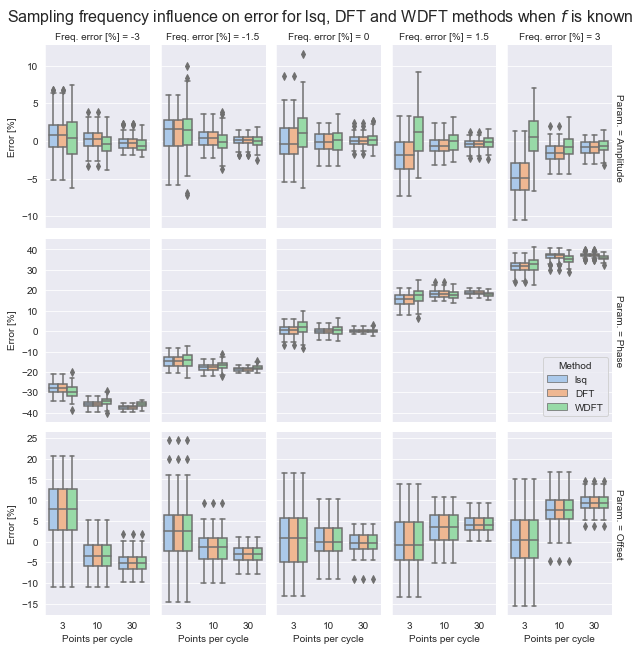

In [6]:
cond = (df_all['# of cycles']<=3)
ax2 = sns.catplot(x='Points per cycle', y='Error [%]', kind='box', 
                  col='Freq. error [%]', row='Param.', sharey='row',
                  height=3,margin_titles=True,
                  hue='Method', palette='pastel', aspect=0.6,
                  data=df_all[cond])
fig = plt.gcf()
sns.move_legend(ax2, "lower right",bbox_to_anchor=(.87, 0.36), frameon=True)
plt.subplots_adjust(top=0.94)
my_suptitle = fig.suptitle(r'Sampling frequency influence on error for lsq, DFT and WDFT methods when $f$ is known', fontsize=16, y=1.0, x=0.46)
fig.savefig('error_comp.pdf',bbox_inches='tight')
plt.show()


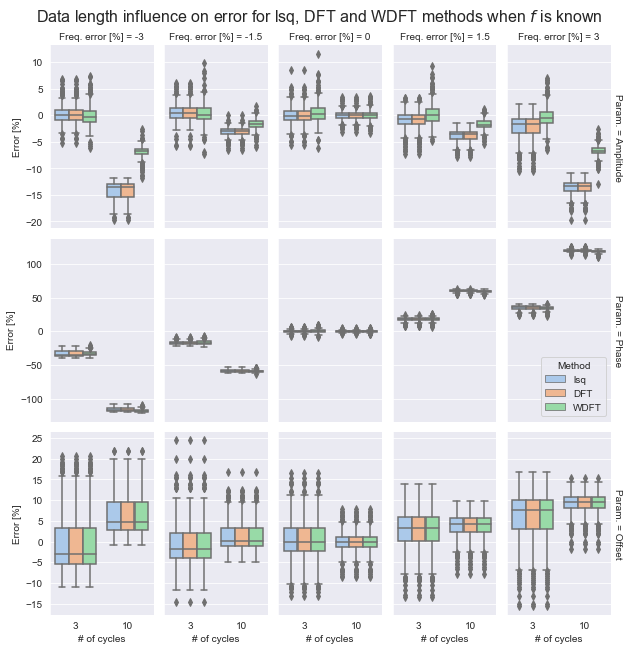

In [7]:
cond = (df_all['# of cycles']<=10)
ax2 = sns.catplot(x='# of cycles', y='Error [%]', kind='box', 
                  col='Freq. error [%]', row='Param.', sharey='row',
                  height=3,margin_titles=True,
                  hue='Method', palette='pastel', aspect=0.6,
                  data=df_all[cond])
fig = plt.gcf()
sns.move_legend(ax2, "lower right",bbox_to_anchor=(.87, 0.36), frameon=True)
plt.subplots_adjust(top=0.94)
my_suptitle = fig.suptitle(r'Data length influence on error for lsq, DFT and WDFT methods when $f$ is known', fontsize=16, y=1.0, x=0.46)
fig.savefig('error_comp_ncycles.pdf',bbox_inches='tight')
plt.show()

## Sensitivity to errors in the linearization point when $f$ is unknown

### Functions

#### Least-square method functions

In [8]:
"""
Least-square method when f is known.

:param yData: (1D numpy array) dependent variable.
:param pinvH : pseudo-inverse of H
:return: [A,phi,c] : Amplitude, phase and offset of the signal
"""
def lsq_unknown_f(yData, sampling_freq, po, nIterMax = 300, step_size = 1):
  N_points = yData.size

  last_error = np.inf
  for idx in range(nIterMax):
    t = np.array(range(N_points))/sampling_freq
    [Ao, fo, phio, co] = po

    # Compute Ho and so
    #   partial derivatives
    thetas = 2 * np.pi * fo * t
    partialA = np.sin(thetas) * np.cos(phio) + np.cos(thetas) * np.sin(phio)
    partialf = ( Ao * np.cos(thetas) * 2 * np.pi * t * np.cos(phio) 
              - Ao * np.sin(thetas) * 2 * np.pi * t * np.sin(phio) )
    partialPhi = -Ao * np.sin(thetas) * np.sin(phio) + A * np.cos(thetas) * np.cos(phio)
    partialC = np.ones(t.shape)

    Ho = np.column_stack((partialA, partialf, partialPhi, partialC))
    so =  Ao * np.sin(2 * np.pi * fo * t + phio) + co - np.matmul(Ho,[Ao, fo, phio, co])
    
    # Compute the pseudo-inverse of Ho
    pinvHo = np.linalg.pinv(Ho)
    
    # Find x_lsq = pinvHo * (y - so)
    x_lsq = np.matmul(pinvHo,(yData-so))

    # Update current estimate
    po = po + step_size*( x_lsq - po )

    # Interrupt loop if converged
    [Ao, fo, phio, co] = po
    t = np.array(range(N_points))/sampling_freq
    error = np.linalg.norm( yData - (Ao * np.sin(2 * np.pi * fo * t + phio) + co) )
    if np.abs(error - last_error)<1e-10:
      break
    last_error = error
    
    phio = phio%(2*np.pi)
    x_lsq = [Ao, fo, phio, co]
  
  return x_lsq

#### DFT and WDFT methods functions

In [9]:
"""
DFT method when f is known.

:param yData: (1D numpy array) dependent variable.
:param signal_freq: expected signal frequency
:param sampling_freq: sampling frequency
:param sin_model: considers phase for a sin function
:param step: frequency step used during search
:param ndec: number of search iterations
:return: [A,signal_freq,phi,c] : Amplitude, frequency, phase and offset of the signal
"""
def DFT_unknown_f(yData, signal_freq, sampling_freq, sin_model = False, step = 0.1, nsteps = 20, ndec = 4):
  N = yData.size
  
  A_max = -np.inf
  for dec in range(ndec):
    for f_idx in np.arange(signal_freq-(nsteps*step/2), signal_freq+(nsteps*step/2), step):
      X = 0
      for n in range(N):
        X += yData[n] * np.exp(-2j * np.pi * f_idx * n / sampling_freq)
      A = 2 * np.abs(X) / N
      if A > A_max:
        A_max = A;
        signal_freq = f_idx
        phi = np.arctan2(X.imag,X.real)
    step = step / 10
  
  c = np.mean(yData)

  if sin_model: # considers phase for a sin function
    phi = phi + np.pi/2

  return [A_max,signal_freq,phi,c]

"""
DFT method when f is known appling Hamming window to the signal.

:param yData: (1D numpy array) dependent variable.
:param signal_freq: expected signal frequency
:param sampling_freq: sampling frequency
:param sin_model: considers phase for a sin function
:return: [A,phi,c] : Amplitude, phase and offset of the signal
"""
def DFT_unknown_f_windowed(yData, signal_freq, sampling_freq, sin_model = False, step = 0.1, nsteps = 20, ndec = 4):
  N = yData.size

  # Apply Hamming window to the signal
  window = [(0.54 + 0.46*np.cos(2 * np.pi * (n-(N-1)/2) / (N-1)))  for n in range(N)]
  yData_windowed = yData * window
  Nw = N*np.mean(window)

  A_max = -np.inf
  for dec in range(ndec):
    for f_idx in np.arange(signal_freq-(nsteps*step/2), signal_freq+(nsteps*step/2), step):
      X = 0
      for n in range(N):
        X += yData_windowed[n] * np.exp(-2j * np.pi * f_idx * n / sampling_freq)
      A = 2 * np.abs(X) / Nw
      if A > A_max:
        A_max = A;
        signal_freq = f_idx
        phi = np.arctan2(X.imag,X.real)
    step = step / 10
  
  c = np.mean(yData)

  if sin_model: # considers phase for a sin function
    phi = phi + np.pi/2

  return [A_max,signal_freq,phi,c]

#### Usage example

In [10]:
# Generate a discrete sinusoidal signal with noise
N = 1000              # Number of measurements (aprox. 21 cycles)
sampling_freq = 1000  # Sampling frequency, in Hz
t = np.array(range(N))/sampling_freq
f = 10.555            # Signal frequency in Hz
A = 2                 # Signal amplitude
phi = np.pi/4         # Signal phase
c = 0.5               # Signal offset
y = A*np.sin(2*np.pi*f*t + phi) + c + np.random.normal(scale=0.1, size=len(t))

#   initial guess
fo = 11.0
po = [2.5, fo, 0.0, 0.0] # [Ao, fo, phio, co]

x_lsq = lsq_unknown_f(y, sampling_freq, po, nIterMax=100)

# Print the estimated parameters
[A_est, freq, phi_est, c_est] = x_lsq
print(f'Real frequency: {f:.4f}Hz; Estimated peak frequency = {freq:.4f}Hz; Error: {100*(freq-f)/f:.2f}%')
print(f'Real amplitude: {A:.4f}; Estimated amplitude: {A_est:.4f}; Error: {100*(A_est-A)/A:.2f}%')
print(f'Real phase: {phi:.4f}; Estimated phase: {phi_est:.4f}; Error: {100*(phi_est-phi)/phi:.2f}%')

x_lsq = DFT_unknown_f(y, fo, sampling_freq, sin_model = True)

# Print the estimated parameters
[A_est, freq, phi_est, c_est] = x_lsq
print(f'Real frequency: {f:.4f}Hz; Estimated peak frequency = {freq:.4f}Hz; Error: {100*(freq-f)/f:.2f}%')
print(f'Real amplitude: {A:.4f}; Estimated amplitude: {A_est:.4f}; Error: {100*(A_est-A)/A:.2f}%')
print(f'Real phase: {phi:.4f}; Estimated phase: {phi_est:.4f}; Error: {100*(phi_est-phi)/phi:.2f}%')

x_lsq = DFT_unknown_f_windowed(y, fo, sampling_freq, sin_model = True)

# Print the estimated parameters
[A_est, freq, phi_est, c_est] = x_lsq
print(f'Real frequency: {f:.4f}Hz; Estimated peak frequency = {freq:.4f}Hz; Error: {100*(freq-f)/f:.2f}%')
print(f'Real amplitude: {A:.4f}; Estimated amplitude: {A_est:.4f}; Error: {100*(A_est-A)/A:.2f}%')
print(f'Real phase: {phi:.4f}; Estimated phase: {phi_est:.4f}; Error: {100*(phi_est-phi)/phi:.2f}%')

Real frequency: 10.5550Hz; Estimated peak frequency = 10.5532Hz; Error: -0.02%
Real amplitude: 2.0000; Estimated amplitude: 2.0034; Error: 0.17%
Real phase: 0.7854; Estimated phase: 0.7907; Error: 0.68%
Real frequency: 10.5550Hz; Estimated peak frequency = 10.5551Hz; Error: 0.00%
Real amplitude: 2.0000; Estimated amplitude: 2.0240; Error: 1.20%
Real phase: 0.7854; Estimated phase: 0.7780; Error: -0.94%
Real frequency: 10.5550Hz; Estimated peak frequency = 10.5540Hz; Error: -0.01%
Real amplitude: 2.0000; Estimated amplitude: 2.0059; Error: 0.29%
Real phase: 0.7854; Estimated phase: 0.7881; Error: 0.34%


#### Simulating data (sensitivity to errors in the linearization point)

In [11]:
index = ['Method', 'N', 'Points per cycle', '# of cycles',
         'Param.', 'Error [%]', '|Error| [%]', 'F_lp error [%]',
         'Max. nbr. of iter.', 'Step size']


N_simulations = 100
f_error_vec = [-3, -1.5, 0, 1.5, 3] # frequency error (%)
N_per_cycle_vec = [3, 10, 30]
Ncycles_vec = [3, 10]
step_size_vec = [1]
nIterMax_vec = [300]

start_time = time.perf_counter() # to keep track of progress
current_iteration = 0
iterations = len(f_error_vec)*len(N_per_cycle_vec)*N_simulations

df2_lst = []
for f_error in f_error_vec:
  for N_per_cycle in N_per_cycle_vec: # points per cycle

    # Generate a discrete sinusoidal signal with noise
    N = 1000              # Number of measurements
    sampling_freq = 1000  # Sampling frequency, in Hz
    t = np.array(range(N))/sampling_freq
    A = 2                 # Signal amplitude
    phi = np.pi/4         # Signal phase
    c = 0.5               # Signal offset
    f = sampling_freq / N_per_cycle # Signal frequency in Hz
    y_clean = A*np.sin(2*np.pi*f*t + phi) + c

    #   initial guess
    f_lp = f*(1+(f_error/100))
    po = [A, f_lp, phi, c] # [Ao, fo, phio, co]

    for idx in range(N_simulations):
      current_iteration += 1
      elapsed_time = time.perf_counter() - start_time
      progress = current_iteration/iterations
      print(f'Elapsed_time = {elapsed_time/60:.2f}min, total = {(elapsed_time/progress)/60:.2f}min, {100*progress:.1f}%    ', end = "\r")
      
      y = y_clean + np.random.normal(scale=0.1, size=len(t))
      for nIterMax in nIterMax_vec:
        for Ncycles in Ncycles_vec:
          for step_size in step_size_vec:
            size = Ncycles * N_per_cycle
            yData = y[:size]

            [A_est_lsq, freq_est_lsq, phi_est_lsq,c_est_lsq] = lsq_unknown_f(yData,sampling_freq, po, nIterMax=nIterMax, step_size=step_size)
            A_error_lsq = 100*(A_est_lsq-A)/A
            freq_error_lsq = 100*(freq_est_lsq-f)/f
            phi_error_lsq = 100*(phi_est_lsq-phi)/phi
            c_error_lsq = 100*(c_est_lsq-c)/c
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Amplitude', A_error_lsq, np.abs(A_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df2_lst.append(df)
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Frequency', freq_error_lsq, np.abs(A_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df2_lst.append(df)
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Phase', phi_error_lsq, np.abs(phi_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df2_lst.append(df)
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Offset', c_error_lsq, np.abs(c_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df2_lst.append(df)
            
df2_all = pd.concat(df2_lst, ignore_index=True)
df2_all.tail(5)    

,Method,N,Points per cycle,# of cycles,Param.,Error [%],|Error| [%],F_lp error [%],Max. nbr. of iter.,Step size
11995,lsq,90,30,3,Offset,0.439067,0.439067,3,300,1
11996,lsq,300,30,10,Amplitude,0.253681,0.253681,3,300,1
11997,lsq,300,30,10,Frequency,0.024785,0.253681,3,300,1
11998,lsq,300,30,10,Phase,-1.154595,1.154595,3,300,1
11999,lsq,300,30,10,Offset,0.733362,0.733362,3,300,1


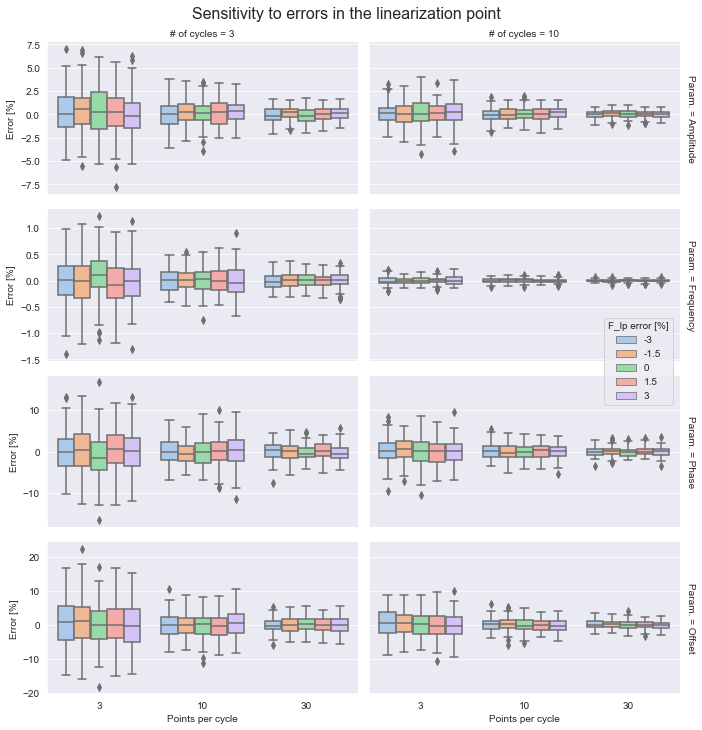

In [12]:
cond = ((df2_all['# of cycles']<=10)&(df2_all['Method']=='lsq'))
ax2 = sns.catplot(x='Points per cycle', y='Error [%]', kind='box', 
                  col='# of cycles', 
                  row='Param.', 
                  #sharey='none', 
                  sharey='row',
                  height=2.5,margin_titles=True,
                  palette='pastel', aspect=2, hue='F_lp error [%]', 
                  data=df2_all[cond])
fig = plt.gcf()
sns.move_legend(ax2, "lower right",bbox_to_anchor=(.87, 0.45), frameon=True)
plt.subplots_adjust(top=0.96)
my_suptitle = fig.suptitle(f'Sensitivity to errors in the linearization point', fontsize=16, y=1.01, x=0.45)
fig.savefig('error_linpoint.pdf',bbox_inches='tight')
plt.show()

#### Simulating data (methods comparison)

In [13]:
index = ['Method', 'N', 'Points per cycle', '# of cycles',
         'Param.', 'Error [%]', '|Error| [%]', 'F_lp error [%]',
         'Max. nbr. of iter.', 'Step size']


N_simulations = 100
f_error_vec = [-3, -1.5, 0, 1.5, 3] # frequency error (%)
N_per_cycle_vec = [3, 30]
Ncycles_vec = [3, 10]
step_size_vec = [1]
nIterMax_vec = [300]

start_time = time.perf_counter() # to keep track of progress
current_iteration = 0
iterations = len(f_error_vec)*len(N_per_cycle_vec)*N_simulations

step = 0.05
nsteps = 40

df3_lst = []
for f_error in f_error_vec:
  for N_per_cycle in N_per_cycle_vec: # points per cycle

    # Generate a discrete sinusoidal signal with noise
    N = 1000              # Number of measurements
    sampling_freq = 1000  # Sampling frequency, in Hz
    t = np.array(range(N))/sampling_freq
    A = 2                 # Signal amplitude
    phi = np.pi/4         # Signal phase
    c = 0.5               # Signal offset
    f = sampling_freq / N_per_cycle # Signal frequency in Hz
    y_clean = A*np.sin(2*np.pi*f*t + phi) + c

    #   initial guess
    f_lp = f*(1+(f_error/100))
    po = [A, f_lp, phi, c] # [Ao, fo, phio, co]

    for idx in range(N_simulations):
      current_iteration += 1
      elapsed_time = time.perf_counter() - start_time
      progress = current_iteration/iterations
      print(f'Elapsed_time = {elapsed_time/60:.2f}min, total = {(elapsed_time/progress)/60:.2f}min, {100*progress:.1f}%    ', end = "\r")
      
      y = y_clean + np.random.normal(scale=0.1, size=len(t))
      for nIterMax in nIterMax_vec:
        for Ncycles in Ncycles_vec:
          for step_size in step_size_vec:
            size = Ncycles * N_per_cycle
            yData = y[:size]

            [A_est_lsq, freq_est_lsq, phi_est_lsq,c_est_lsq] = lsq_unknown_f(yData,sampling_freq, po, nIterMax=nIterMax, step_size=step_size)
            A_error_lsq = 100*(A_est_lsq-A)/A
            freq_error_lsq = 100*(freq_est_lsq-f)/f
            phi_error_lsq = 100*(phi_est_lsq-phi)/phi
            c_error_lsq = 100*(c_est_lsq-c)/c
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Amplitude', A_error_lsq, np.abs(A_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df3_lst.append(df)
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Frequency', freq_error_lsq, np.abs(A_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df3_lst.append(df)
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Phase', phi_error_lsq, np.abs(phi_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df3_lst.append(df)
            data = ['lsq', size, N_per_cycle, Ncycles,
                    'Offset', c_error_lsq, np.abs(c_error_lsq), f_error,
                    nIterMax, step_size]
            df = pd.DataFrame(data, index).T
            df3_lst.append(df)
            
          step_size = -1
          [A_est, freq_est, phi_est,c_est] = DFT_unknown_f(yData, f_lp, sampling_freq, sin_model = True, step = step, nsteps = nsteps)
          A_error = 100*(A_est-A)/A
          freq_error = 100*(freq_est-f)/f
          phi_error = 100*(phi_est-phi)/phi
          c_error = 100*(c_est-c)/c
          method = 'DFT'
          data = [method, size, N_per_cycle, Ncycles,
                  'Amplitude', A_error, np.abs(A_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)
          data = [method, size, N_per_cycle, Ncycles,
                  'Frequency', freq_error, np.abs(A_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)
          data = [method, size, N_per_cycle, Ncycles,
                  'Phase', phi_error, np.abs(phi_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)
          data = [method, size, N_per_cycle, Ncycles,
                  'Offset', c_error, np.abs(c_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)          

          [A_est, freq_est, phi_est,c_est] = DFT_unknown_f_windowed(yData, f_lp, sampling_freq, sin_model = True, step = step, nsteps = nsteps)
          A_error = 100*(A_est-A)/A
          freq_error = 100*(freq_est-f)/f
          phi_error = 100*(phi_est-phi)/phi
          c_error = 100*(c_est-c)/c
          method = 'WDFT'
          data = [method, size, N_per_cycle, Ncycles,
                  'Amplitude', A_error, np.abs(A_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)
          data = [method, size, N_per_cycle, Ncycles,
                  'Frequency', freq_error, np.abs(A_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)
          data = [method, size, N_per_cycle, Ncycles,
                  'Phase', phi_error, np.abs(phi_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)
          data = [method, size, N_per_cycle, Ncycles,
                  'Offset', c_error, np.abs(c_error), f_error,
                  nIterMax, step_size]
          df = pd.DataFrame(data, index).T
          df3_lst.append(df)          


df3_all = pd.concat(df3_lst, ignore_index=True)
df3_all.tail(5)    

,Method,N,Points per cycle,# of cycles,Param.,Error [%],|Error| [%],F_lp error [%],Max. nbr. of iter.,Step size
23995,DFT,300,30,10,Offset,0.904607,0.904607,3,300,-1
23996,WDFT,300,30,10,Amplitude,-0.021935,0.021935,3,300,-1
23997,WDFT,300,30,10,Frequency,0.0024,0.021935,3,300,-1
23998,WDFT,300,30,10,Phase,-1.014762,1.014762,3,300,-1
23999,WDFT,300,30,10,Offset,0.904607,0.904607,3,300,-1


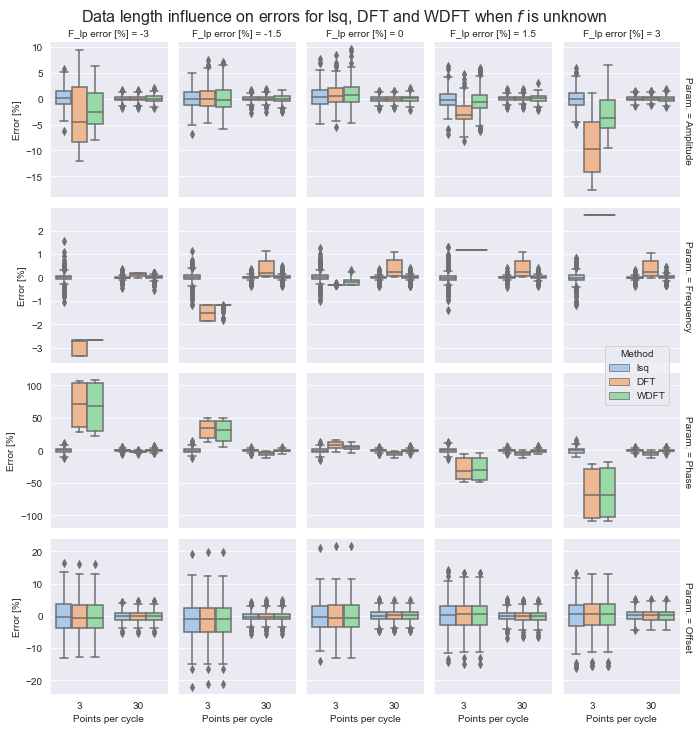

In [14]:
cond = ((df3_all['# of cycles']<=10))
ax2 = sns.catplot(x='Points per cycle', y='Error [%]', kind='box', 
                  col='F_lp error [%]', 
                  row='Param.', 
                  #sharey='none', 
                  sharey='row',
                  height=2.5,margin_titles=True,
                  palette='pastel', aspect=0.8, hue='Method', 
                  data=df3_all[cond])
fig = plt.gcf()
sns.move_legend(ax2, "lower right",bbox_to_anchor=(.87, 0.45), frameon=True)
plt.subplots_adjust(top=0.96)
my_suptitle = fig.suptitle(r'Data length influence on errors for lsq, DFT and WDFT when $f$ is unknown', fontsize=16, y=1.01, x=0.45)
fig.savefig('error_linpoint_methods.pdf',bbox_inches='tight')
plt.show()

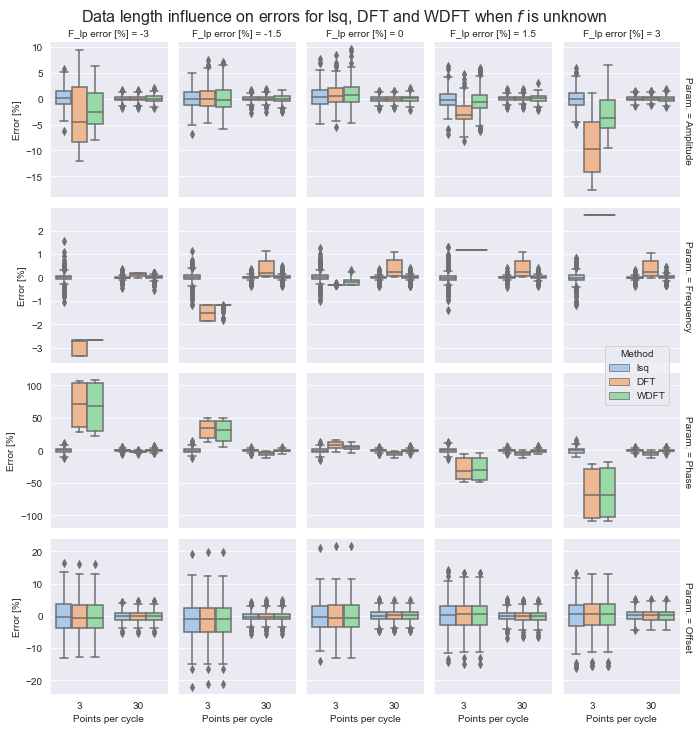

In [15]:
cond = ((df3_all['# of cycles']<=10))
ax2 = sns.catplot(x='Points per cycle', y='Error [%]', kind='box', 
                  col='F_lp error [%]', 
                  row='Param.', 
                  #sharey='none', 
                  sharey='row',
                  height=2.5,margin_titles=True,
                  palette='pastel', aspect=0.8, hue='Method', 
                  data=df3_all[cond])
fig = plt.gcf()
sns.move_legend(ax2, "lower right",bbox_to_anchor=(.87, 0.45), frameon=True)
plt.subplots_adjust(top=0.96)
my_suptitle = fig.suptitle(r'Data length influence on errors for lsq, DFT and WDFT when $f$ is unknown', fontsize=16, y=1.01, x=0.45)
fig.savefig('error_linpoint_methods.pdf',bbox_inches='tight')
plt.show()